# <a id='toc1_'></a>[CNN Baseline model](#toc0_)

This notebook aims to provide a baseline CNN model for comparison with our auto-supervised approach to the deepfake audio detection.

The model choosed was [ConvNeXt-Tiny-AT](https://huggingface.co/topel/ConvNeXt-Tiny-AT). It is a CNN based audio model pretrained on the [AudioSet](http://research.google.com/audioset/index.html) dataset, to classify between 632 audio event classes in a collection of 2,084,320 human-labeled 10-second sound clips drawn from YouTube videos.

The model was pretrained on a supervised way, and will be fine-tuned also in a supervised way, to see how it compares with the self-supervised approach.

## Summary

* [Part 1: Notebook setup](#part_01)
* [Part 2: Data loading](#part_02)
* [Part 3: Model fine tuning](#part_03)
* [Part 4: Model evaluation](#part_04)

## Notebook setup <a class="anchor" id="part_01"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as TF
import torchaudio
import torchaudio.functional as TAF
import pathlib

from audioset_convnext_inf.pytorch.convnext import ConvNeXt
from audioset_convnext_inf.utils.utilities import read_audioset_label_tags

PATH_TO_DATASET = "/media/elias/ssd1tb/Projects/AUDIOS/datasets/release"

RANDOM_STATE = 7 # the biblical number of perfection =)

model = ConvNeXt.from_pretrained("topel/ConvNeXt-Tiny-AT", map_location='cpu')

print(
    "# params:",
    sum(param.numel() for param in model.parameters() if param.requires_grad),
)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if "cuda" in str(device):
    model = model.to(device)

/media/elias/ssd1tb/Projects/AUDIOS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using ckpt from HF
# params: 28222767


## Data loading  <a class="anchor" id="part_02"></a>

In [50]:
train_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'splits', 'by_file', "files-downstream_train.csv"))
train_metadata_df.head()

,file,speaker,id,gender,label
0,fake_voices/Alcione_F018_Fake/1000_fake.wav,Alcione,F018,F,spoof
1,fake_voices/Alcione_F018_Fake/100_fake.wav,Alcione,F018,F,spoof
2,fake_voices/Alcione_F018_Fake/101_fake.wav,Alcione,F018,F,spoof
3,fake_voices/Alcione_F018_Fake/102_fake.wav,Alcione,F018,F,spoof
4,fake_voices/Alcione_F018_Fake/103_fake.wav,Alcione,F018,F,spoof


In [51]:
validation_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'splits', 'by_file', "files-downstream_val.csv"))
validation_metadata_df.head()

,file,speaker,id,gender,label
0,fake_voices/Aurea_F036_Fake/1000_fake.wav,Aurea,F036,F,spoof
1,fake_voices/Aurea_F036_Fake/100_fake.wav,Aurea,F036,F,spoof
2,fake_voices/Aurea_F036_Fake/101_fake.wav,Aurea,F036,F,spoof
3,fake_voices/Aurea_F036_Fake/102_fake.wav,Aurea,F036,F,spoof
4,fake_voices/Aurea_F036_Fake/103_fake.wav,Aurea,F036,F,spoof


In [53]:
# subsampling

train_metadata_df = train_metadata_df.groupby('speaker', group_keys=False).apply(lambda x: x.sample(n=200, random_state=42))
validation_metadata_df = validation_metadata_df.groupby('speaker', group_keys=False).apply(lambda x: x.sample(n=200, random_state=7))

/tmp/ipykernel_16437/547419777.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_metadata_df = train_metadata_df.groupby('speaker', group_keys=False).apply(lambda x: x.sample(n=200, random_state=42))
/tmp/ipykernel_16437/547419777.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validation_metadata_df = validation_metadata_df.groupby('speaker', group_keys=False).apply(lambda x: x.sample(n=200, ra

### Dataset and dataloader

In [ ]:
from torch.utils.data import Dataset
from tqdm import tqdm

class AudioDataset(Dataset):
    """Dataset class from pytorch
    
    Cache dataset indicates if we want to load the entire dataset preprocessed
    on RAM (only works if 32GB memory or higher)"""
    def __init__(self, metadata_df: pd.DataFrame, audio_dir: str, cache_dataset = False):
        self.metadata_df = metadata_df
        self.audio_dir = audio_dir
        
        self.metadata_df['label_encoded'] = self.metadata_df['label'].map({
            "bona-fide": 0,
            "spoof": 1
        })
        
        self.cache_dataset = cache_dataset
        
        if cache_dataset:
            self.load_all_audios()
            
            
    def load_all_audios(self):
        """Load and preprocess all audios from the memory"""
        self.audios_cache = []

        for filename in tqdm(self.metadata_df['file'], desc="Loading audio files"):
            audio_path = os.path.join(self.audio_dir, filename)
            self.audios_cache.append(self.load_and_preprocess_audio(audio_path))

    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, idx):
        if self.cache_dataset:
            return self.audios_cache[idx], self.metadata_df.iloc[idx]['label_encoded']
        
        # if not cache, load the individual file
        row = self.metadata_df.iloc[idx]
        # Load audio file
        audio_path = os.path.join(self.audio_dir, row['file'])
        
        return self.load_and_preprocess_audio(audio_path), row['label_encoded']
    
    
    def load_and_preprocess_audio(self,path_to_audio, sample_rate = 32000, target_seconds_length = 10):
        """Load an audio of the memory and preprocess it to be adequate to ConvNeXt model"""
        audio_target_length = target_seconds_length * sample_rate  # 10 s

        waveform, sample_rate_ = torchaudio.load(path_to_audio)
        if sample_rate_ != sample_rate:
            waveform = TAF.resample(
                waveform,
                sample_rate_,
                sample_rate,
                )

        if waveform.shape[-1] < audio_target_length:
            # padding waveform
            missing = max(audio_target_length - waveform.shape[-1], 0)
            waveform = TF.pad(waveform, (0,missing), mode="constant", value=0.0)
        elif waveform.shape[-1] > audio_target_length:
            # cropping waveform
            waveform = waveform[:, :audio_target_length]

        waveform = waveform.contiguous()
        
        return waveform
    
dataset_train = AudioDataset(train_metadata_df, PATH_TO_DATASET, cache_dataset=False)
dataset_val = AudioDataset(validation_metadata_df, PATH_TO_DATASET, cache_dataset=False)

## Model fine-tuning  <a class="anchor" id="part_03"></a>

### Making a simple prediction

In [54]:
def load_and_preprocess_audio(path_to_audio, sample_rate = 32000, target_seconds_length = 10):
    """Load an audio of the memory and preprocess it to be adequate to ConvNeXt model"""
    audio_target_length = target_seconds_length * sample_rate  # 10 s

    waveform, sample_rate_ = torchaudio.load(path_to_audio)
    if sample_rate_ != sample_rate:
        print("Resampling from %d to 32000 Hz"%sample_rate_)
        waveform = TAF.resample(
            waveform,
            sample_rate_,
            sample_rate,
            )

    if waveform.shape[-1] < audio_target_length:
        # padding waveform
        missing = max(audio_target_length - waveform.shape[-1], 0)
        waveform = TF.pad(waveform, (0,missing), mode="constant", value=0.0)
    elif waveform.shape[-1] > audio_target_length:
        # cropping waveform
        waveform = waveform[:, :audio_target_length]

    waveform = waveform.contiguous()
    
    return waveform

In [55]:
train_metadata_df

,file,speaker,id,gender,label
22255,real_voices/Alcione_F018/F018-0860.wav,Alcione,F018,F,bona-fide
353,fake_voices/Alcione_F018_Fake/418_fake.wav,Alcione,F018,F,spoof
21728,real_voices/Alcione_F018/F018-0333.wav,Alcione,F018,F,bona-fide
905,fake_voices/Alcione_F018_Fake/915_fake.wav,Alcione,F018,F,spoof
21684,real_voices/Alcione_F018/F018-0289.wav,Alcione,F018,F,bona-fide
...,...,...,...,...,...
20857,fake_voices/Tulio_M027_Fake/516_fake.wav,Tulio,M027,M,spoof
45498,real_voices/Tulio_M027/M027-0105.wav,Tulio,M027,M,bona-fide
21250,fake_voices/Tulio_M027_Fake/870_fake.wav,Tulio,M027,M,spoof
21088,fake_voices/Tulio_M027_Fake/724_fake.wav,Tulio,M027,M,spoof


Resampling from 16000 to 32000 Hz


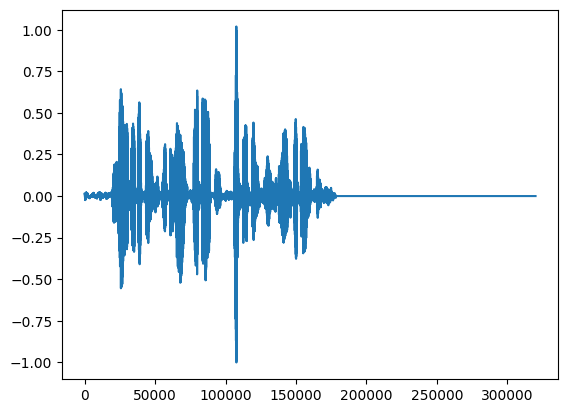

In [56]:
import matplotlib.pyplot as plt

sample_audio = train_metadata_df.file.iloc[0]
audio_path = os.path.join(PATH_TO_DATASET, sample_audio)

waveform = load_and_preprocess_audio(audio_path)

# seeing a waveform
plt.plot(waveform[0])

In [57]:
# making a output
waveform = waveform.to(device)

with torch.no_grad():
    model.eval()
    output = model(waveform)

logits = output["clipwise_logits"]
print("logits size:", logits.size())

probs = output["clipwise_output"]
# Equivalent: probs = torch.sigmoid(logits)
print("probs size:", probs.size())

lb_to_ix, ix_to_lb, id_to_ix, ix_to_id = read_audioset_label_tags('/media/elias/ssd1tb/Projects/AUDIOS/src/notebooks/labels_audioset.csv')

threshold = 0.1
sample_labels = np.where(probs[0].clone().detach().cpu() > threshold)[0]
print("\nPredicted labels using activity threshold 0.25:")

for l in sample_labels:
    print("    %s: %.3f"%(ix_to_lb[l], probs[0,l]))

logits size: torch.Size([1, 1])
probs size: torch.Size([1, 1])

Predicted labels using activity threshold 0.25:


### Model architecture adaptation

Our adapdatation is going to be simple: just change from 527 classes of the original AudioSet dataset to two nodes, predicting the spoof and bonafide probability

In [59]:
from torchinfo import summary

summary(model, input_size=(1, 320000))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNeXt                                 [1, 1]                    --
├─Spectrogram: 1-1                       [1, 1, 1001, 513]         --
│    └─STFT: 2-1                         --                        --
│    │    └─Conv1d: 3-1                  [1, 513, 1001]            (525,312)
│    │    └─Conv1d: 3-2                  [1, 513, 1001]            (525,312)
├─LogmelFilterBank: 1-2                  [1, 1, 1001, 224]         (114,912)
├─BatchNorm2d: 1-3                       [1, 224, 1001, 1]         448
├─ModuleList: 1-10                       --                        (recursive)
│    └─Sequential: 2-2                   [1, 96, 252, 56]          --
│    │    └─Conv2d: 3-3                  [1, 96, 252, 56]          1,632
│    │    └─LayerNorm: 3-4               [1, 96, 252, 56]          192
├─ModuleList: 1-11                       --                        (recursive)
│    └─Sequential: 2-3                   

In [60]:
model.head_audioset

Linear(in_features=768, out_features=1, bias=True)

In [61]:
# changing the output layer to two classes
from torch import nn
model.head_audioset = nn.Linear(in_features=768, out_features=1).to(device)

### Model training
Let's fine tune our model with the training data, using 10 epochs and a small learning rate.

All the weights are trained here (there are no layers frozen)

In [62]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm

# Hyperparameters
num_epochs = 10
learning_rate = 3e-4
batch_size = 8

train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": []
}

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        inputs, labels = batch[0].to(device), batch[1].float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs.squeeze(1))
        train_loss = criterion(outputs['clipwise_logits'].squeeze(1), labels)
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch[0].to(device), batch[1].float().to(device)
            outputs = model(inputs.squeeze(1))
            val_loss = criterion(outputs['clipwise_logits'].squeeze(1), labels)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_dataloader)

    # Store losses
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

loss_history_df = pd.DataFrame(history)
print("Training complete.")


Epoch [1/10], Train Loss: 0.0048, Validation Loss: 0.0001


KeyboardInterrupt: 

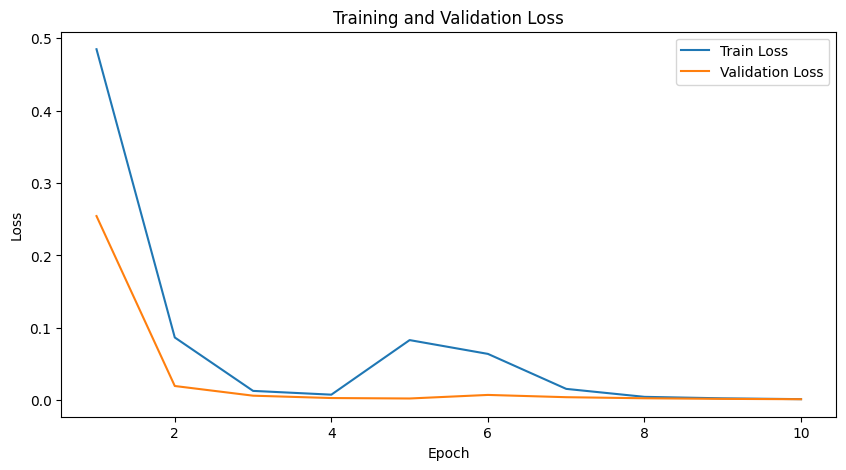

In [28]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history_df["epoch"], loss_history_df["train_loss"], label="Train Loss")
plt.plot(loss_history_df["epoch"], loss_history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Model evaluation <a class="anchor" id="part_04"></a>

Let's evaluate the model acording to the metrics defined on our planning

In [29]:
def make_predictions(model, metadata_df):
    """Make the predictions on the given files on metainfo_df
    
    Return a dataframe with the values of the predictions"""
    output_list = []
    dataloader = DataLoader(dataset=AudioDataset(metadata_df, PATH_TO_DATASET), batch_size=8)

    with torch.no_grad():
        model.eval()
        for batch in tqdm(dataloader, desc=f"Inference", leave=False):
            inputs = batch[0]  # (batch_size, channels, length)
            labels = batch[1].float()  # Convert labels to float for BCE loss

            # Move tensors to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs.squeeze(1))

            output_list.append(outputs['clipwise_output'].to('cpu').numpy())
            
    metadata_df['predict_proba'] = np.concatenate(output_list)
    metadata_df['prediction'] = metadata_df['predict_proba'].round().astype(int)
    
    return metadata_df

train_metadata_df_results = make_predictions(model, train_metadata_df)
train_metadata_df_results['train'] = True

val_metadata_df_results = make_predictions(model, validation_metadata_df)
val_metadata_df_results['train'] = False

results_df = pd.concat([train_metadata_df_results, val_metadata_df_results], axis='rows')
results_df = results_df.reset_index(drop=True)

# standarized way to see the results
results_df.head()

,file,speaker,id,gender,label,label_encoded,predict_proba,prediction,train
0,real_voices/DanielRibeiro_M002/M002-0624.wav,DanielRibeiro,M002,M,bona-fide,0,0.001224,0,True
1,real_voices/JorgeHumberto_M042/M042-0912.wav,JorgeHumberto,M042,M,bona-fide,0,0.001682,0,True
2,fake_voices/Marcio_M011_Fake/320_fake.wav,Marcio,M011,M,spoof,1,0.998394,1,True
3,fake_voices/Alcione_F018_Fake/127_fake.wav,Alcione,F018,F,spoof,1,0.998513,1,True
4,fake_voices/PauloSiqueira_M015_Fake/596_fake.wav,PauloSiqueira,M015,M,spoof,1,0.998274,1,True


### Metrics

In [30]:
from sklearn.metrics import roc_curve
# Split data based on 'train' column
train_results = results_df[results_df['train'] == True]
non_train_results = results_df[results_df['train'] == False]

# Function to calculate TP, FP, FN, TN, Precision, Recall, Accuracy, and F1 Score
def calculate_metrics(df):
    TP = ((df['label_encoded'] == 1) & (df['prediction'] == 1)).sum()
    FP = ((df['label_encoded'] == 0) & (df['prediction'] == 1)).sum()
    FN = ((df['label_encoded'] == 1) & (df['prediction'] == 0)).sum()
    TN = ((df['label_encoded'] == 0) & (df['prediction'] == 0)).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, accuracy, f1_score

# Function to calculate EER
def calculate_EER(df):
    y_true = df['label_encoded']
    y_pred = df['predict_proba']
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer

# Calculate metrics for training entries
train_precision, train_recall, train_accuracy, train_f1_score = calculate_metrics(train_results)
train_eer = calculate_EER(train_results)

# Calculate metrics for non-training (validation) entries
val_precision, val_recall, val_accuracy, val_f1_score = calculate_metrics(non_train_results)
val_eer = calculate_EER(non_train_results)

# Print metrics for training entries
print(f"Train -")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall: {train_recall:.4f}")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1 Score: {train_f1_score:.4f}")
print(f"  EER: {train_eer:.4f}")
print()

# Print metrics for validation entries
print(f"Validation -")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall: {val_recall:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F1 Score: {val_f1_score:.4f}")
print(f"  EER: {val_eer:.4f}")


Train -
  Precision: 1.0000
  Recall: 1.0000
  Accuracy: 1.0000
  F1 Score: 1.0000
  EER: 0.0000

Validation -
  Precision: 1.0000
  Recall: 1.0000
  Accuracy: 1.0000
  F1 Score: 1.0000
  EER: 0.0000


### Confusion matrices

In [31]:
# Function to create and print confusion matrix
def print_confusion_matrix(df, set_name):
    TP = ((df['label_encoded'] == 1) & (df['prediction'] == 1)).sum()
    FP = ((df['label_encoded'] == 0) & (df['prediction'] == 1)).sum()
    FN = ((df['label_encoded'] == 1) & (df['prediction'] == 0)).sum()
    TN = ((df['label_encoded'] == 0) & (df['prediction'] == 0)).sum()

    print(f"{set_name} Confusion Matrix:")
    print(f"          Predicted 0    Predicted 1")
    print(f"Actual 0    {TN:10}    {FP:10}")
    print(f"Actual 1    {FN:10}    {TP:10}\n")

# Print confusion matrix for training and validation sets
print_confusion_matrix(train_results, "Train")
print_confusion_matrix(non_train_results, "Validation")

Train Confusion Matrix:
          Predicted 0    Predicted 1
Actual 0            65             0
Actual 1             0            35

Validation Confusion Matrix:
          Predicted 0    Predicted 1
Actual 0            50             0
Actual 1             0            50



### Saving the model

In [35]:
torch.save(model.state_dict(), '/media/elias/ssd1tb/Projects/AUDIOS/models/baseline_model_state_dict.pth')